In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

img_path = r"C:\Users\Crist\OneDrive\Desktop\COMPUTER VISION\aea project\POSE-ESTIMATION\data\images\val\118cube.jpeg"

class processing:
    
    def __init__(self, img_path, xyxy):
        self.img = cv2.imread(img_path)
        self.original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        self.m = self.img.shape[0]
        self.n = self.img.shape[1]
        self.xyxy = np.array(xyxy)
        self.keypoints = np.zeros((0, 0), dtype=np.int32)
        
    def show_original(self):
        plt.imshow(self.original_img)
        plt.title("Immagine originale")
        plt.show()
        return self
    
    def show(self):
        plt.imshow(self.img)
        plt.title("Immagine")
        plt.show()
        return self
    
    def show_color(self):
        plt.imshow(self.img_color)
        plt.title("Immagine colorata")
        plt.show()
        return self

    def orange_mask(self):
        
        r = self.img[:, :, 2] 
        g= self.img[:, :, 1] 
        b = self.img[:, :, 0] 
        
        mask_red = (r > 150).astype(np.uint8)
        mask_green = (g > 50).astype(np.uint8)
        mask_blue = (b < 100).astype(np.uint8)
            
        combined_mask = cv2.bitwise_and(mask_red, mask_green, mask_blue)
        result = np.zeros_like(self.img)

        result[combined_mask == 1] = (255, 255, 255)
        self.img = result
        
        return self
    
    def Keypoints(self): 
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)

        orb = cv2.ORB_create(nfeatures = 1000)
        kp = orb.detect(gray,None)
        
        kp, des = orb.compute(gray, kp)
        self.img = cv2.drawKeypoints(self.img, kp, None, color=(0,255,0), flags=0)
        return self
        
    def Harris_corner_detection(self, k):
        gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray,800,0.01,150)
        corners = np.intp(corners)
        for i in corners:
            x,y = i.ravel()
            cv2.circle(self.img,(x,y),3,255,-1)
        
        gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        dst = cv2.cornerHarris(gray,2,3,0.04)
        
        dst = cv2.dilate(dst,None)
        
        self.img[dst > k*dst.max()]=[255,0,0]
        
        for i in range (0, self.xyxy[3] - self.xyxy[1] ):
            for j in range (0, self.xyxy[2] - self.xyxy[0] ):
                if dst[i,j] > k*dst.max():
                    self.keypoints = np.append(self.keypoints, dst[i,j])
        return self

    def centroid(self):
        
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            M = cv2.moments(contour)
            
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                
                cv2.circle(self.img, (cx, cy), 5, (0, 255, 0), -1)
        
        max_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(max_contour)

        # Estrae l'angolo di inclinazione dell'ellisse rispetto all'asse x
        angle = ellipse[2]

        image_with_ellipse = self.img.copy()
        cv2.ellipse(self.img, ellipse, (0, 255, 0), 2)
        
        return self
    
    def vertices():
        
        # Esegui la clusterizzazione dei punti chiave
        # Specifica il raggio della vicinanza e il numero minimo di punti per formare un cluster
        dbscan = DBSCAN(eps=10, min_samples=4)
        labels = dbscan.fit_predict(keypoints)

        # Estrai i vertici dai cluster
        vertices = []
        for label in np.unique(labels):
            if label == -1:  # Etichetta per punti non assegnati a nessun cluster
                continue
            cluster_points = keypoints[labels == label]
        # Verifica se il cluster rappresenta un vertice del cubo e aggiungilo alla lista dei vertici se sì
        
        return self

    def principal_axis(self):


        # Trova i contorni dell'oggetto nell'immagine
        contours, _ = cv2.findContours(cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Assicurati che sia stata trovata almeno un contorno
        if len(contours) > 0:
            # Prendi solo il contorno più esterno
            contour = contours[0]
            
            # Calcola il momento dell'oggetto
            M = cv2.moments(contour)
            
            # Calcola il baricentro
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            
            # Calcola il tensore d'inerzia
            mu20 = M['m20'] / M['m00'] - cx**2
            mu02 = M['m02'] / M['m00'] - cy**2
            mu11 = M['m11'] / M['m00'] - cx * cy
            
            # Costruisci il tensore d'inerzia
            inertia_tensor = np.array([[mu20, mu11],
                                       [mu11, mu02]])
            
            # Calcola gli autovalori e gli autovettori del tensore d'inerzia
            eigenvalues, eigenvectors = np.linalg.eig(inertia_tensor)
            
            # Gli autovalori sono ordinati in modo crescente, quindi l'autovalore minimo
            # corrisponde all'asse principale minore, mentre l'autovalore massimo corrisponde
            # all'asse principale maggiore
            
            # Calcola le coordinate degli assi principali
            scale = 300  # Lunghezza degli assi
            principal_minor = (cx + scale * eigenvectors[0, 0], cy + scale * eigenvectors[1, 0])
            principal_major = (cx + scale * eigenvectors[0, 1], cy + scale * eigenvectors[1, 1])
            
            # Disegna gli assi principali sull'immagine
            cv2.line(self.img, (cx, cy), (int(principal_minor[0]), int(principal_minor[1])), (0, 255, 0), 2)
            cv2.line(self.img, (cx, cy), (int(principal_major[0]), int(principal_major[1])), (0, 0, 255), 2)
            
            # Disegna il baricentro sull'immagine
            cv2.circle(self.img, (cx, cy), 5, (255, 0, 0), -1)
    
        return self
    
    def zoom(self):
        self.img = self.img[self.xyxy[1] + 1  : self.xyxy[3] + 1, self.xyxy[0] + 1 : self.xyxy[2] + 1]
       


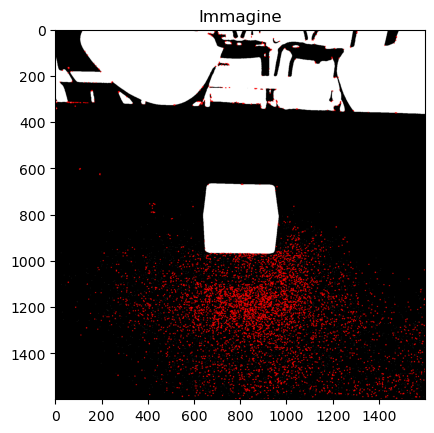

In [2]:
test = processing(img_path, [ 600,      600,      1000,      1000])

#test.zoom()
test.orange_mask()
test.Harris_corner_detection(k = 0.05)
#test.Keypoints()
#test.principal_axis()
#test.centroid()

test.show()




In [3]:
import numpy as np
import cv2
from ultralytics import YOLO 


class object_detection: 

    def __init__(self, capture_index):

        self.capture_index = capture_index
        self.model = self.load_model()
        self.results = []
        self.xyxy = []
        
    def load_model(self):

        model = YOLO('weights.pt')
        return model
    
    def prediction(self):
        
        cap = cv2.VideoCapture(self.capture_index)
        
        while True:
            
            success, img = cap.read()
            results = self.model.track(img, persist = True, stream=False, conf = 0.5, save = True)
            self.results.extend(results)
            
            for r in results:
                
                boxes = r.boxes
                
                for box in boxes:
            
                    x1, y1, x2, y2 = box.xyxy[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) 
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 2)
                    
            cv2.imshow('Webcam', img)
            if cv2.waitKey(1) == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        
    def boxes(self):
        for r in self.results:
            self.xyxy.append(r.boxes.xyxy.cpu().numpy())


object = object_detection(0)
object.prediction()
object.boxes()



0: 480x640 (no detections), 2044.8ms
Speed: 10.2ms preprocess, 2044.8ms inference, 19.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\Crist\runs\pose\predict11

0: 480x640 (no detections), 1958.2ms
Speed: 5.9ms preprocess, 1958.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\Crist\runs\pose\predict11

0: 480x640 (no detections), 1028.4ms
Speed: 8.2ms preprocess, 1028.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\Crist\runs\pose\predict11

0: 480x640 (no detections), 979.7ms
Speed: 0.0ms preprocess, 979.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\Crist\runs\pose\predict11

0: 480x640 (no detections), 1016.4ms
Speed: 0.0ms preprocess, 1016.4ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\Crist\runs\pose\predict11

0: 480x640 (no detections), 986.3ms
Speed: 3.3ms prepr